## 1. Download dei dati ##

In [2]:
# Download dataset
#!wget https://www.zemris.fer.hr/projects/LicensePlates/english/baza_slika.zip
# Unzip file zip
#!unzip -o -j baza_slika.zip "*.jpg" -d dataset

## 2. Preparazione dei dati ##

In [1]:
# Divisione dataset 
import os

import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io

from PIL import Image

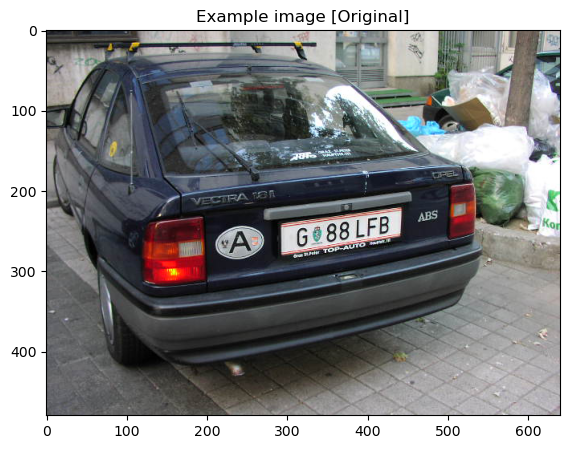

In [2]:
# Percorso alla cartella che contiene le immagini
datasetPath = "dataset"

# Lista per salvare le immagini caricate
imgList = []

# Scorrimento di tutti i file nella cartella
for fileName in os.listdir(datasetPath):
    if fileName.lower().endswith(".jpg"):
        filePath = os.path.join(datasetPath, fileName)
        img = Image.open(filePath)
        imgList.append(img)

# Mostriamo un'immagine
index = np.random.randint(0,len(imgList))
plt.figure(figsize=(15,5))
plt.imshow(imgList[index])
plt.title('Example image [Original]')
plt.show()

In [3]:
# Importiamo le librerie per il training
import torch
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
# Divisione dell'intero dataset in training set, validation set e test set (Circa 80%, 10% e 10%)
trainSet, valSet, testSet = random_split(imgList, [0.8, 0.1, 0.1])

# Creazione dei DataLoader per i set
batchSize = 60
numWorkers = 4

trainDataload = DataLoader(trainSet, batch_size=batchSize, shuffle=True, num_workers=numWorkers)
valDataload = DataLoader(valSet, batch_size=batchSize, num_workers=numWorkers)
testDataload = DataLoader(testSet, batch_size=batchSize, num_workers=numWorkers)

print("Effettuata suddivisione:")
print(f"- Training-set: {len(trainSet)} campioni.")
print(f"- Validation-set: {len(valSet)} campioni.")
print(f"- Test-set: {len(testSet)} campioni.")

Effettuata suddivisione:
- Training-set: 403 campioni.
- Validation-set: 50 campioni.
- Test-set: 50 campioni.


In [5]:
from skimage.transform import rescale
from skimage.util import view_as_windows

In [ ]:

def extract_patches(img: np.ndarray, patch_size: tuple = (96, 96), stride: int = 24) -> np.ndarray:
    """
    Estrae blocchi sovrapposti da un'immagine usando finestra scorrevole.

    Args:
        img (np.ndarray): immagine di input in formato H x W x C.
        patch_size (tuple): dimensione dei blocchi (altezza, larghezza).
        stride (int): passo di estrazione in pixel.

    Returns:
        np.ndarray: array di blocchi con shape (n_h, n_w, patch_h, patch_w, C).
    """
    # Aggiungiamo dimensione canale nel passo per view_as_windows
    step = (stride, stride, img.shape[2])
    window_shape = (patch_size[0], patch_size[1], img.shape[2])
    # view_as_windows restituisce shape (n_h, n_w, 1, patch_h, patch_w, C)
    windows = view_as_windows(img, window_shape, step)
    # Rimuoviamo la dimensione singola
    patches = windows.squeeze(2)
    patches = rescale(patches,2,order=2)
    return patches

def downscale_via_average(img: str,
                           patch_size: tuple = (96, 96),
                           stride: int = 24) -> Image.Image:
    """
    Effettua il downscale di un'immagine calcolando la media di blocchi sovrapposti.

    Args:
        img_path (str): percorso dell'immagine.
        patch_size (tuple): dimensione dei blocchi.
        stride (int): passo di estrazione.

    Returns:
        PIL.Image.Image: immagine downscalata.
    """
    # Carica e converte in array
    arr = np.array(img)

    # Estrai patch
    patches = extract_patches(arr, patch_size, stride)
    n_h, n_w, _, _, c = patches.shape

    # Inizializza immagine di output
    down_h = n_h
    down_w = n_w
    downscaled = np.zeros((down_h, down_w, c), dtype=np.uint8)

    # Per ogni patch, calcola la media per canale
    for i in range(n_h):
        for j in range(n_w):
            patch = patches[i, j]
            mean_color = patch.mean(axis=(0, 1))
            downscaled[i, j] = mean_color.astype(np.uint8)

                # Converte in immagine PIL
    return Image.fromarray(downscaled)


imgLow = downscale_via_average(imgList[0])

plt.figure()
plt.imshow(imgList[0])
plt.title('Example image [Highres]')
plt.show()
plt.figure()
plt.imshow(imgLow)
plt.title('Example image [Lowres]')
plt.show()